## Semi-supervised Clustering in Image Analysis

In [58]:
# Aesthetics
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
# General
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os
import random
# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
from plotly import graph_objs as go
import plotly.express as px
# Machine Learning
# Dimensionality Reduction
from sklearn.manifold import Isomap, TSNE
from sklearn.decomposition import PCA
# Clustering
from sklearn.cluster import KMeans
from sklearn.semi_supervised import LabelSpreading
# Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

import tensorflow as tf
from tensorflow.keras import layers, models
import plotly.io as pio

pio.renderers.default = 'notebook'

In [59]:
RANDOM_SEED = 42
def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
seed_everything()

In [60]:
data_path = '/Users/akshatha/Desktop/Data_Science_Sem3/master_thesis/Master_Thesis/Dataset'

train_file_path = os.path.join(data_path, 'train.csv')
test_file_path = os.path.join(data_path, 'test.csv')

print(f'Training File path: {train_file_path}')
print(f'Test Files path: {test_file_path}')

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

Training File path: /Users/akshatha/Desktop/Data_Science_Sem3/master_thesis/Master_Thesis/Dataset/train.csv
Test Files path: /Users/akshatha/Desktop/Data_Science_Sem3/master_thesis/Master_Thesis/Dataset/test.csv


In [61]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [62]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


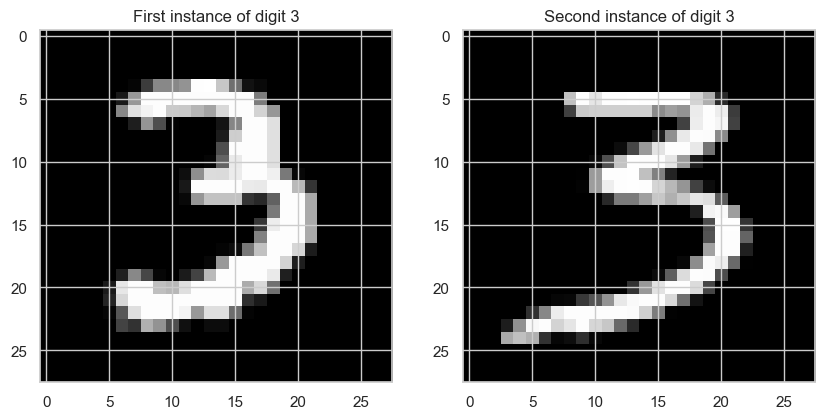

In [63]:
image1 = train_df.iloc[9,1:].values.reshape(28,28)
image2 = train_df.iloc[25,1:].values.reshape(28,28)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(image1, cmap='gray')
plt.title('First instance of digit 3')

plt.subplot(1,2,2)
plt.imshow(image2, cmap='gray')
plt.title('Second instance of digit 3')

plt.show()

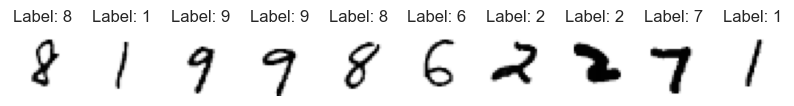

In [64]:
train_labels = train_df['label'].values
train_data = train_df.drop(['label'], axis=1).values
num_examples = 10
random_indices = np.random.choice(train_data.shape[0], num_examples, replace=False)
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_examples, i+1)
    plt.imshow(train_data[idx].reshape(28, 28), cmap='Greys')
    plt.title(f"Label: {train_labels[idx]}")
    plt.axis('off')
plt.show()

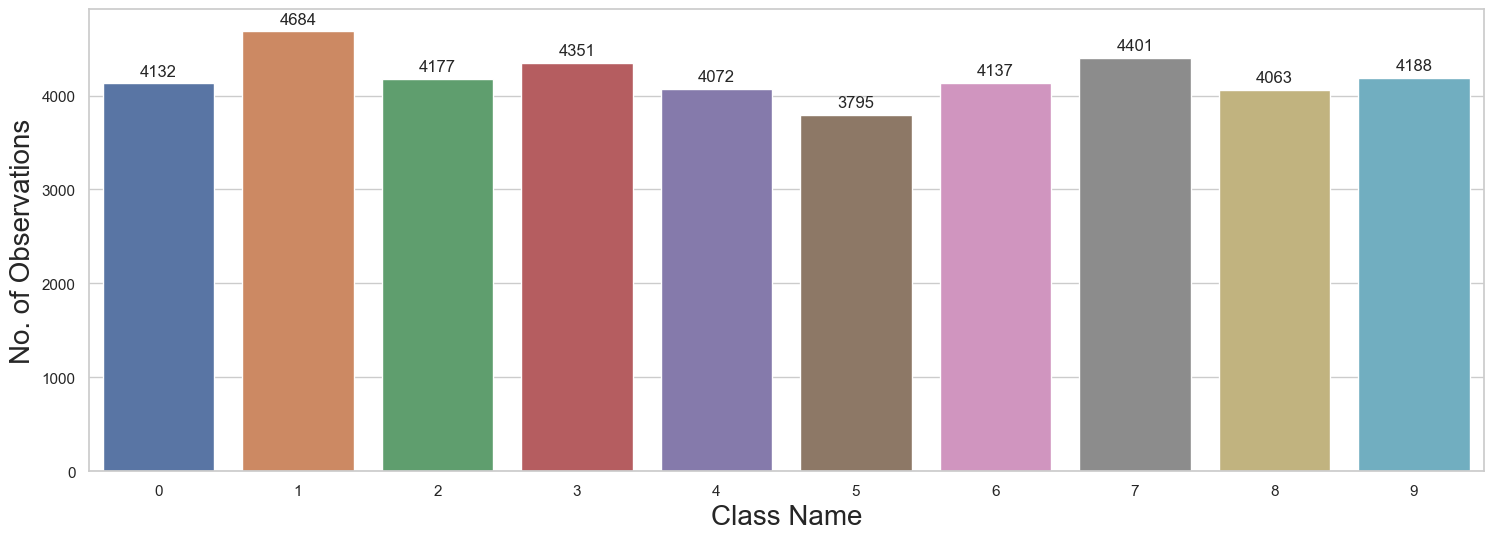

In [65]:
ax = plt.subplots(figsize=(18, 6))
sns.set_style("whitegrid")
bar_plot = sns.countplot(x='label', data=train_df)
plt.ylabel("No. of Observations", size=20)
plt.xlabel("Class Name", size=20)

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', label_type='edge', fontsize=12, padding=3)

plt.show()

In [66]:
iso = Isomap(n_components=2)

# Using only 1/10 of the data as full data takes a lot of time to run
iso.fit(train_df.drop(['label'], axis=1)[::10])
data_2d = iso.transform(train_df.drop(['label'], axis=1)[::10])

iso_df = pd.DataFrame(data_2d)
iso_df['label'] = train_df.label.values[::10]
iso_df.columns = ['x', 'y', 'label']
# Converting label to string to get discrete colors in plot
iso_df['label'] = iso_df['label'].astype(str)
iso_df.head()

x            y label
0 -3164.522146 -2876.064133     1
1 -1392.993977 -3268.073825     8
2  -505.836838 -2730.492689     8
3 -1892.122937 -2603.238878     8
4 -1155.536391 -2238.244455     9

In [106]:
fig = px.scatter(iso_df, x='x', y='y', color='label', hover_data=['label'])
fig.update_layout(title='MNIST Isomap 2D')
fig.write_image("mnist_isomap_2d.png", width=1000, height=500, scale=2)
fig.show()  

![MNIST Isomap 2D](mnist_isomap_2d.png)

In [68]:
iso = Isomap(n_components=3)

# Using only 1/10 of the data as full data takes a lot of time to run
iso.fit(train_df.drop(['label'], axis=1)[::10])
data_3d = iso.transform(train_df.drop(['label'], axis=1)[::10])

iso_df = pd.DataFrame(data_3d)
iso_df['label'] = train_df.label.values[::10]
iso_df.columns = ['x', 'y', 'z', 'label']
# Converting label to string to get discrete colors in plot
iso_df['label'] = iso_df['label'].astype(str)
iso_df.head()

x            y            z label
0 -3164.522146 -2876.064133  2769.434567     1
1 -1392.993977 -3268.073825  2537.656185     8
2  -505.836838 -2730.492689  1403.573999     8
3 -1892.122937 -2603.238878  1973.673223     8
4 -1155.536391 -2238.244455 -2228.778622     9

In [69]:
fig = px.scatter_3d(iso_df, x='x', y='y', z='z', color='label', hover_data=['label'])
fig.update_layout(title ='MNIST Isomap 3D')
fig.show()

In [70]:
pca = PCA(n_components=2)

# Using only 1/5 of the data as full data takes a lot of time to run
pca.fit(train_df.drop(['label'], axis=1)[::5])
data_2d = pca.transform(train_df.drop(['label'], axis=1)[::5])

pca_df = pd.DataFrame(data_2d)
pca_df['label'] = train_df.label.values[::5]
pca_df.columns = ['x', 'y', 'label']
# Converting label to string to get discrete colors in plot
pca_df['label'] = pca_df['label'].astype(str)
pca_df.head()

x           y label
0 -689.649976 -684.843619     1
1  492.013847  194.769615     0
2  251.532408  368.983271     8
3 -965.636424 -269.214044     1
4 -253.193349 -244.224089     8

In [71]:
fig = px.scatter(pca_df, x='x', y='y', color='label',
                 hover_data=['label'])
fig.update_layout(title = 'MNIST PCA 2D')
fig.show()

In [72]:
pca = PCA(n_components=3)

# Using only 1/5 of the data as full data takes a lot of time to run
pca.fit(train_df.drop(['label'], axis=1)[::5])
data_3d = pca.transform(train_df.drop(['label'], axis=1)[::5])

pca_df = pd.DataFrame(data_3d)
pca_df['label'] = train_df.label.values[::5]
pca_df.columns = ['x', 'y', 'z', 'label']
# Converting label to string to get discrete colors in plot
pca_df['label'] = pca_df['label'].astype(str)
pca_df.head()

x           y           z label
0 -689.649371 -684.842103  180.441962     1
1  492.014066  194.773127   29.496154     0
2  251.532825  368.980792  517.974140     8
3 -965.636714 -269.212459  -18.302643     1
4 -253.192783 -244.221331  306.334444     8

In [73]:
fig = px.scatter_3d(pca_df, x='x', y='y', z='z', color='label',
                    hover_data=['label'])
fig.update_layout(title = 'MNIST PCA 3D')
fig.show()

In [74]:
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)

# Using only 1/5 of the data as full data takes a lot of time to run
data_2d = tsne.fit_transform(train_df.drop(['label'], axis=1)[::5])

tsne_df = pd.DataFrame(data_2d)
tsne_df['label'] = train_df.label.values[::5]
tsne_df.columns = ['x', 'y', 'label']
# Converting label to string to get discrete colors in plot
tsne_df['label'] = tsne_df['label'].astype(str)
tsne_df.head()

x          y label
0 -54.973747 -39.513020     1
1  59.208115 -13.389258     0
2 -21.755135 -11.108450     8
3 -50.486458 -12.374542     1
4 -17.735485 -25.174314     8

In [75]:
fig = px.scatter(tsne_df, x='x', y='y', color='label',
                 hover_data=['label'])
fig.update_layout(title = 'MNIST tSNE 2D')
fig.show()

In [76]:
tsne = TSNE(n_components=3, random_state=RANDOM_SEED)

# Using only 1/5 of the data as full data takes a lot of time to run
data_3d = tsne.fit_transform(train_df.drop(['label'], axis=1)[::5])

tsne_df = pd.DataFrame(data_3d)
tsne_df['label'] = train_df.label.values[::5]
tsne_df.columns = ['x', 'y', 'z', 'label']
# Converting label to string to get discrete colors in plot
tsne_df['label'] = tsne_df['label'].astype(str)
tsne_df.head()

x          y          z label
0 -13.878677  -5.060273  14.828371     1
1  18.223419 -11.924116   7.233977     0
2  -5.197411  -1.964661  -5.070707     8
3 -13.127986  -1.138468   0.515834     1
4  -6.714522  -9.224581  -5.961275     8

In [77]:
fig = px.scatter_3d(tsne_df, x='x', y='y', z='z', color='label',
                    hover_data=['label'])
fig.update_layout(title = 'MNIST tSNE 3D')
fig.show()

In [78]:
labels = train_df['label'].values
features = train_df.drop(columns=['label']).values
features = features / 255.0

In [79]:
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)

In [80]:
gmm = GaussianMixture(n_components=10, random_state=42)
cluster_labels = gmm.fit_predict(reduced_features)

In [81]:
def map_cluster_to_label(cluster_labels, true_labels):
    label_mapping = {}
    for cluster in np.unique(cluster_labels):
        mask = cluster_labels == cluster
        most_common = np.bincount(true_labels[mask]).argmax()
        label_mapping[cluster] = most_common
    return np.vectorize(label_mapping.get)(cluster_labels)

# Map the cluster labels to the true labels
predicted_labels = map_cluster_to_label(cluster_labels, labels)

In [82]:
reduced_df = pd.DataFrame(reduced_features, columns=['x', 'y'])
reduced_df['Cluster'] = cluster_labels.astype(str)

fig = px.scatter(reduced_df, x='x', y='y', color='Cluster', title='MNIST t-SNE 2D with Unsupervised Clustering')
fig.show()

In [83]:
accuracy = accuracy_score(labels, predicted_labels)
ari = adjusted_rand_score(labels, cluster_labels)
print(f'Clustering Accuracy: {accuracy * 100:.2f}%')
print(f'Adjusted Rand Index: {ari:.2f}')

Clustering Accuracy: 86.69%
Adjusted Rand Index: 0.78


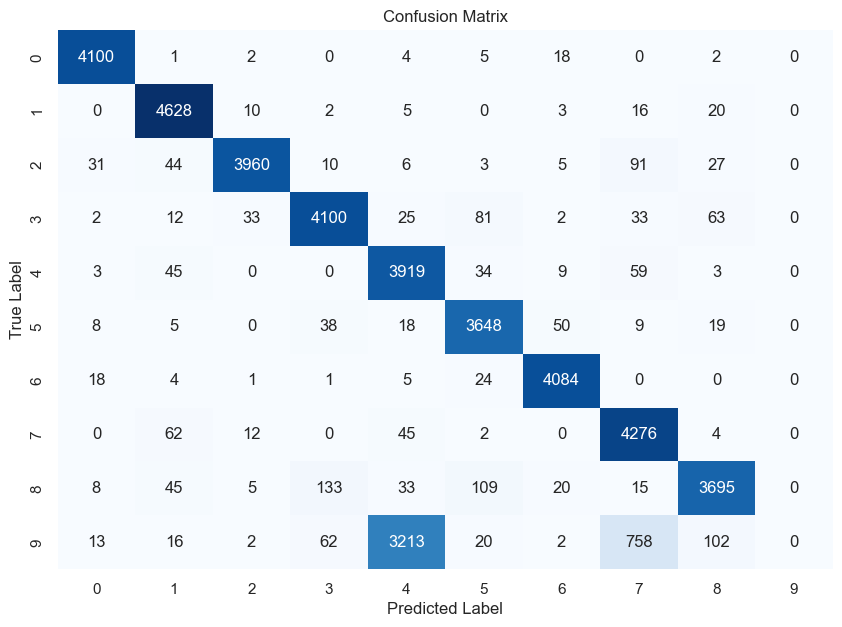

In [84]:
# Confusion matrix
conf_matrix = confusion_matrix(labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Supervised Learning

In [85]:
X = train_df.drop(columns=['label']).values.reshape(-1, 28, 28, 1)  # Reshape for CNN
y = train_df['label'].values
X = X / 255.0 
X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42)

In [86]:
# Defining the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [87]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8569 - loss: 0.4711 - val_accuracy: 0.9786 - val_loss: 0.0681
Epoch 2/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9806 - loss: 0.0598 - val_accuracy: 0.9858 - val_loss: 0.0442
Epoch 3/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9868 - loss: 0.0399 - val_accuracy: 0.9857 - val_loss: 0.0480
Epoch 4/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9887 - loss: 0.0324 - val_accuracy: 0.9863 - val_loss: 0.0422
Epoch 5/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9929 - loss: 0.0227 - val_accuracy: 0.9870 - val_loss: 0.0439
Epoch 6/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9939 - loss: 0.0177 - val_accuracy: 0.9860 - val_loss: 0.0466
Epoch 7/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9951 - loss: 0.0160 - val_accuracy: 0.9860 - val_loss: 0.0489
Epoch 8/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9946 - loss: 0.0149 - 

In [88]:
feature_extractor = models.Model(inputs=model.inputs,
                                 outputs=model.layers[-2].output)
# Extracting features from the training data
features = feature_extractor.predict(X_train)

# Applying KMeans clustering to the extracted features
n_clusters = 10  # Number of clusters (since we have 10 digits)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(features)

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [89]:
# Dimensionality reduction using t-SNE
tsne_sem = TSNE(n_components=2, random_state=42)
features_tsne = tsne_sem.fit_transform(features)

In [90]:
tsne_df_sem = pd.DataFrame(features_tsne, columns=['x', 'y'])
tsne_df_sem['label'] = clusters.astype(str)

fig = px.scatter(tsne_df_sem, x='x', y='y', color='label', hover_data=['label'])
fig.update_layout(title='MNIST t-SNE 2D with Supervised Clustering')
fig.show()

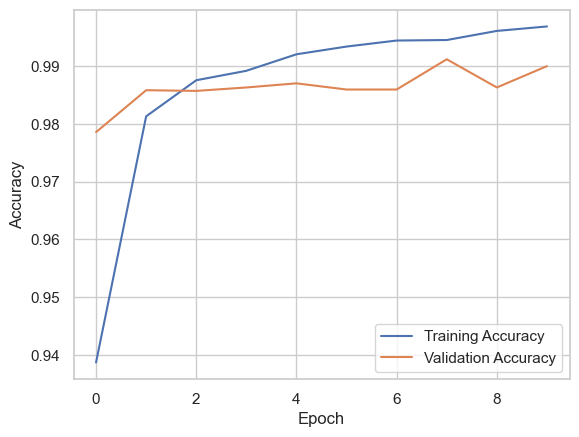

In [91]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [92]:
X_test = test_df.values.reshape(-1, 28, 28, 1)  # Reshape for CNN
X_test = X_test / 255.0
y_pred = np.argmax(model.predict(X_test), axis=-1)

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


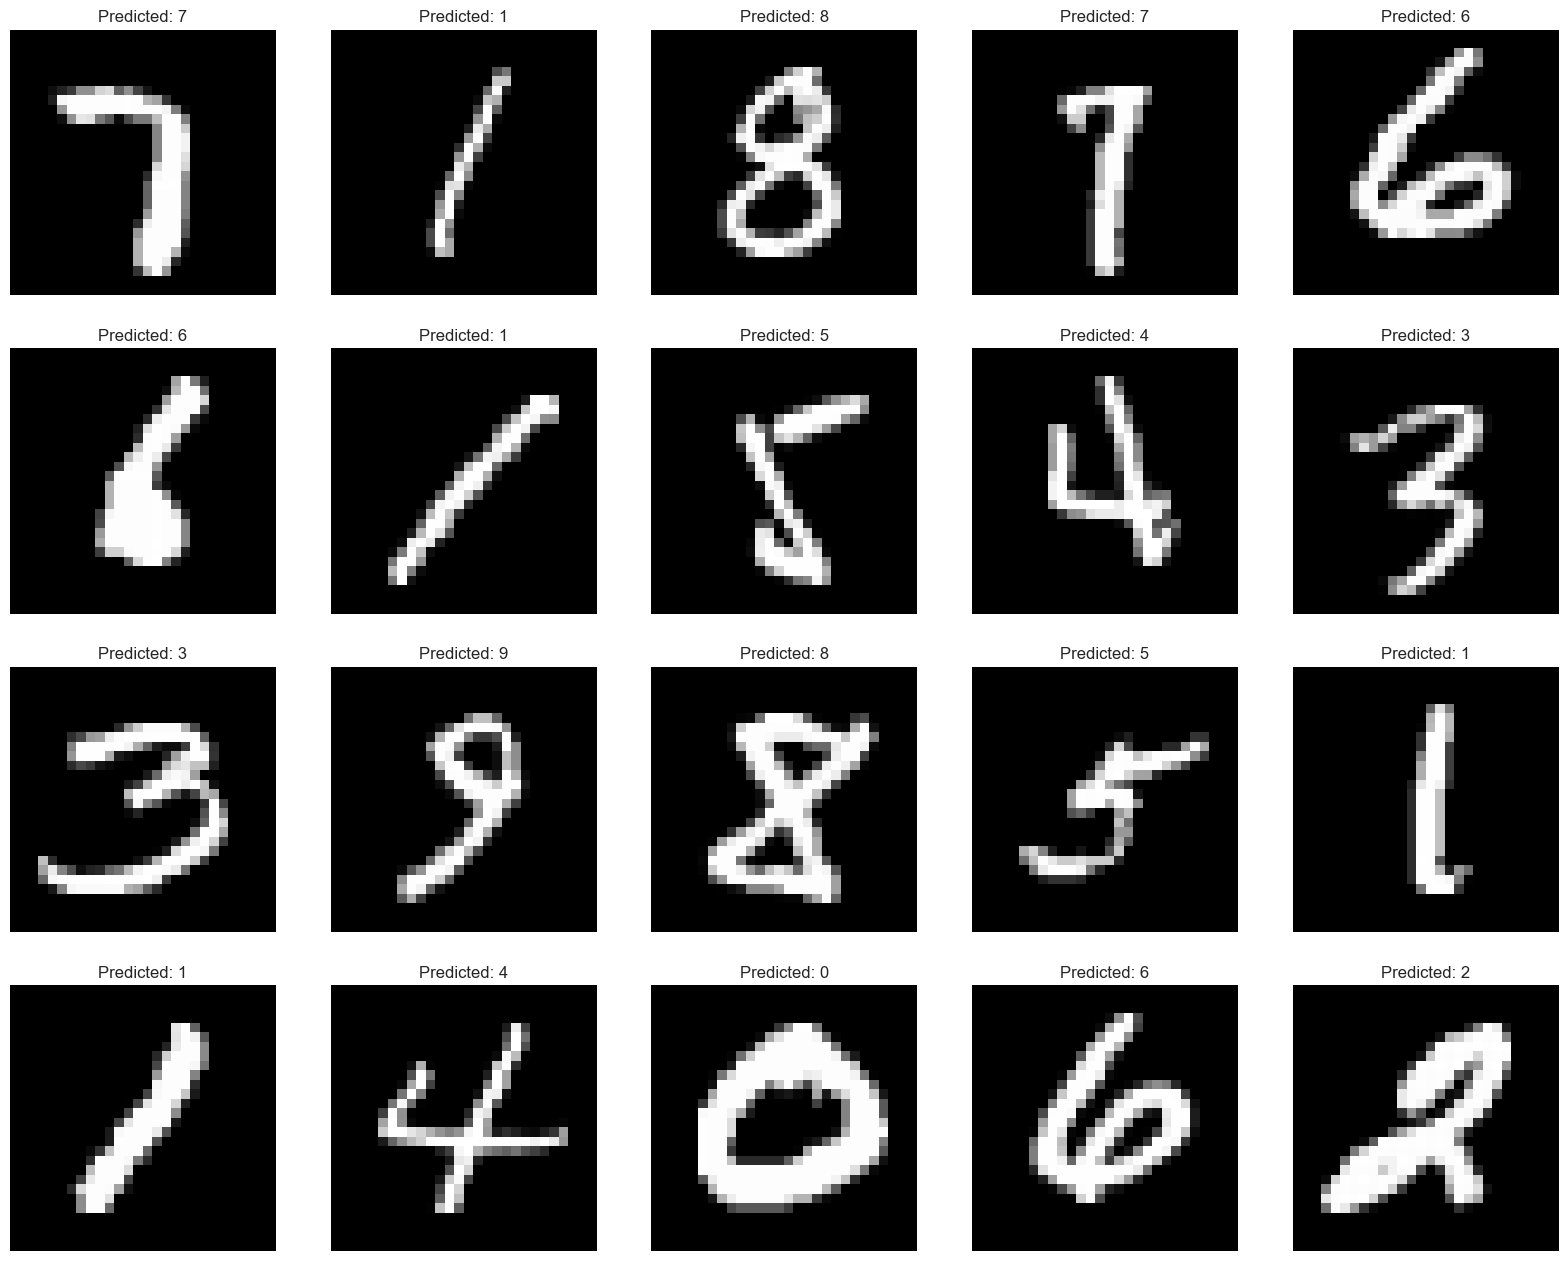

In [93]:
X_test = test_df.values.reshape(-1, 28, 28, 1) / 255.0
y_pred = np.argmax(model.predict(X_test), axis=-1)

num_examples = 20
random_indices = np.random.choice(X_test.shape[0], num_examples, replace=False)
plt.figure(figsize=(20, 20))

for i, idx in enumerate(random_indices):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {y_pred[idx]}')
    plt.axis('off')
plt.show()

## Semi-supervised Clustering with LabelSpreading

In [94]:
# Preprocessing the data
X = train_df.drop(columns=['label']).values.astype(float)
y = train_df['label'].values

# Normalizing the features
X = X / 255.0
# Split labeled and unlabeled data
labeled_size = 0.1
RANDOM_SEED = 42
X_labeled, X_unlabeled, y_labeled, y_unlabeled_true = train_test_split(X, y, train_size=labeled_size, random_state=RANDOM_SEED, stratify=y)


In [95]:
# Combine labeled and unlabeled data
X_combined = np.vstack((X_labeled, X_unlabeled))
y_combined = np.concatenate([y_labeled, [-1]*len(X_unlabeled)])

pca = PCA(n_components=50, random_state=RANDOM_SEED)
X_combined_pca = pca.fit_transform(X_combined)

In [96]:
label_spread = LabelSpreading(kernel='knn', alpha=0.2)
label_spread.fit(X_combined_pca, y_combined)

LabelSpreading(kernel='knn')

In [97]:
y_combined_pred = label_spread.transduction_
y_unlabeled_pred = y_combined_pred[-len(X_unlabeled):]
y_labeled_pred = y_combined_pred[:len(X_labeled)]
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
X_combined_tsne = tsne.fit_transform(X_combined_pca)

In [98]:
tsne_df = pd.DataFrame(X_combined_tsne, columns=['x', 'y'])
tsne_df['label'] = y_combined_pred.astype(str)
fig = px.scatter(tsne_df, x='x', y='y', color='label', hover_data=['label'])
fig.update_layout(title='MNIST t-SNE 2D with Semi-supervised Clustering')
fig.show()

Accuracy Score: 0.9497089947089947
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      3719
           1       0.96      0.99      0.97      4216
           2       0.97      0.94      0.96      3759
           3       0.94      0.92      0.93      3916
           4       0.97      0.93      0.95      3665
           5       0.93      0.94      0.94      3415
           6       0.95      0.98      0.97      3723
           7       0.94      0.96      0.95      3961
           8       0.96      0.91      0.93      3657
           9       0.90      0.94      0.92      3769

    accuracy                           0.95     37800
   macro avg       0.95      0.95      0.95     37800
weighted avg       0.95      0.95      0.95     37800



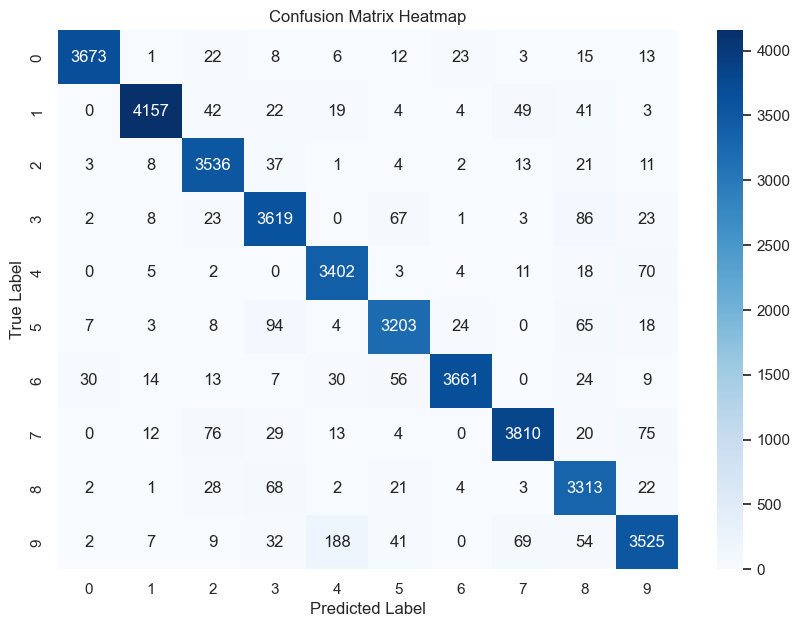

In [99]:
accuracy = accuracy_score(y_unlabeled_true, y_unlabeled_pred)

print("Accuracy Score:", accuracy)
print("Classification Report:\n", classification_report(y_unlabeled_true, y_unlabeled_pred))
conf_matrix = confusion_matrix(y_unlabeled_pred, y_unlabeled_true)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

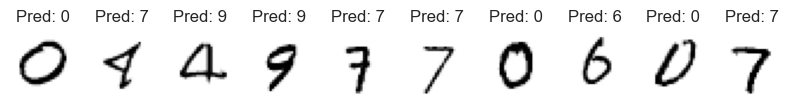

In [100]:
num_examples = 10
random_indices = np.random.choice(len(X_unlabeled), num_examples, replace=False)
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_examples, i+1)
    plt.imshow(X_unlabeled[idx].reshape(28, 28), cmap='Greys')
    plt.title(f"Pred: {y_unlabeled_pred[idx]}")
    plt.axis('off')
plt.show()